# Preprocessing

In [1]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

In [4]:
df_final = pd.read_csv('dataset/preprocessed_dataset.csv')
metadata = pd.read_csv('dataset/movie_metadata.csv')
metadata['movie_title'] = metadata.movie_title.str.lower().str.strip()
data = pd.merge(metadata,df_final,on = ['movie_title'],suffixes=['_x',''])
# Drop duplicate & unnecessary
data.drop(columns = ['genres_x','director_name_x','actor_1_name_x','actor_2_name_x','actor_3_name_x','plot_keywords','movie_imdb_link','country'],inplace = True)

In [8]:
# One hot encode categorical vars, Multi ho encode genre, Min-max to 0-1 numerical
scaler = MinMaxScaler()
cate = ['color','language','content_rating','director_name','actor_1_name','actor_2_name','actor_3_name']
drop = ['movie_title','genres','comb']
# Drop movie with na in categorical vars
data.dropna(subset=cate,inplace = True)
data.reset_index(drop = True,inplace = True)
# Basic info
print(data.shape)
# Schema
data.iloc[0,:]

(4961, 26)


color                                                                    Color
num_critic_for_reviews                                                   723.0
duration                                                                 178.0
director_facebook_likes                                                    0.0
actor_3_facebook_likes                                                   855.0
actor_1_facebook_likes                                                  1000.0
gross                                                              760505847.0
movie_title                                                             avatar
num_voted_users                                                         886204
cast_total_facebook_likes                                                 4834
facenumber_in_poster                                                       0.0
num_user_for_reviews                                                    3054.0
language                                            

In [9]:
train = scaler.fit_transform(data.drop(columns = cate+drop))
train = pd.DataFrame(train,columns = data.drop(columns = cate+drop).columns)

encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
onehot = encoder.fit_transform(data[cate])
onehot = pd.DataFrame(onehot,columns = [x for y in encoder.categories_ for x in y])

genre = set([y for x in data['genres'].str.split() for y in x ])
multihot = pd.DataFrame(columns = genre)
for item in data.genres.str.split():
    temp = pd.DataFrame(np.zeros([1,multihot.shape[1]]),columns = genre)
    for g in item:
        temp[g] = 1
    multihot = multihot.append(temp)
multihot.reset_index(drop = True,inplace = True)

# Train contains transformed data and has same index as data
train = pd.concat([train,onehot,multihot],axis = 1)
train.fillna(0,inplace = True)
print(train.shape)
train.head()

(4961, 10235)


,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,Drama,Documentary,Fiction,War,Comedy,Western,Sport,Thriller,Biography,History
0,0.889163,0.509677,0.000000,0.037174,0.001563,1.000000,0.524453,0.007361,0.000000,0.603479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.370690,0.480645,0.024478,0.043478,0.062500,0.406840,0.278865,0.073622,0.000000,0.244515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.740148,0.412903,0.000000,0.007000,0.017188,0.263080,0.163255,0.017816,0.023256,0.196284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.000000,0.464516,0.956522,1.000000,0.042188,0.589253,0.677216,0.162561,0.000000,0.533702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.567734,0.361290,0.020652,0.023043,0.001000,0.096066,0.125579,0.002852,0.023256,0.145681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [10]:
kmeans = KMeans(n_clusters=500)
kmeans.fit(train)
l1 = pd.DataFrame(kmeans.labels_)
data['l1'] = l1

186    79
13     56
34     49
16     49
10     44
       ..
25      1
493     1
360     1
312     1
440     1
Length: 500, dtype: int64


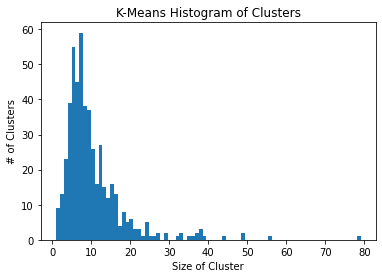

In [11]:
print(l1.value_counts())
plt.hist(l1.value_counts(),bins = l1.value_counts().max())
plt.xlabel('Size of Cluster')
plt.ylabel('# of Clusters')
plt.title('K-Means Histogram of Clusters')
plt.show()

In [12]:
dbscan = DBSCAN(eps = 2.8,min_samples = 2)
dbscan.fit(train)
l2 = pd.DataFrame(dbscan.labels_)
data['l2'] = l2

-1      2693
 14      686
 174      24
 45       24
 105      23
        ... 
 281       2
 282       2
 114       2
 284       2
 419       2
Length: 421, dtype: int64


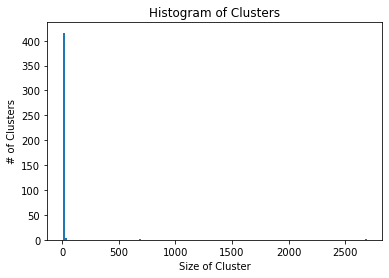

In [13]:
print(l2.value_counts())
plt.hist(l2.value_counts(),bins = 140)
plt.xlabel('Size of Cluster')
plt.ylabel('# of Clusters')
plt.title('Histogram of Clusters')
plt.show()

## Evaluation

In [14]:
# Append cosine sim between input and centroid
from sklearn.metrics.pairwise import cosine_similarity
sim = []
for i in range(len(train)):
    label = int(data['l1'][i])
    sim.append(cosine_similarity(kmeans.cluster_centers_[label:(label+1),:],train.iloc[i:(i+1),:])[0][0])
len(sim)
data['sim'] = sim

In [15]:
# Grab clusters that has more than 20 movies to compare with Cosine sim
# Takes ~10 min to execute
clus_over20 = l1.value_counts()[l1.value_counts()>20].index.tolist()
clus_over20 = [x[0] for x in clus_over20]

std_k_list = []
std_cos_list = []
for i in range(len(clus_over20)):
    input_ind = data.loc[data['l1']==clus_over20[i]].index[0]
    # kmeans
    clus = train.loc[data['l1']==data['l1'][input_ind],:]
    sim_k = []
    for i in range(len(clus)):
        sim_k.append(cosine_similarity(train.iloc[input_ind:(input_ind+1),:],clus.iloc[i:(i+1),:]))
    sim_k = np.array(sim_k).flatten()
    sim_k.sort()
    sim_k = sim_k[-20:]
    std_k_list.append(np.std(sim_k))
    # cos 
    sim_cos = []
    for i in range(len(train)):
        sim_cos.append(cosine_similarity(train.iloc[input_ind:(input_ind+1),:],train.iloc[i:(i+1),:]))
    sim_cos = np.array(sim_cos).flatten()
    sim_cos.sort()
    sim_cos = sim_cos[-20:]
    std_cos_list.append(np.std(sim_cos))


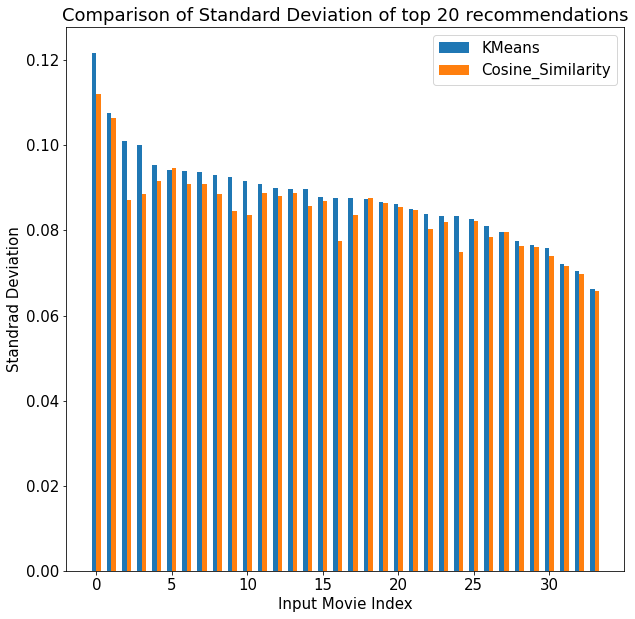

In [16]:
# Make side by side bar plot
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 15})
res = pd.DataFrame({'km':std_k_list,'cos' : std_cos_list})
res = res.sort_values(by = 'km',ascending=False)
ran = np.arange(len(res))

plt.bar(ran - 0.15, res['km'], width=0.3, label = 'KMeans')
plt.bar(ran + 0.15, res['cos'], width=0.3, label = 'Cosine_Similarity')
plt.ylabel('Standrad Deviation')
plt.xlabel('Input Movie Index')
plt.title('Comparison of Standard Deviation of top 20 recommendations')
plt.legend()
plt.show()

In [17]:
# Paired two sample t test
ttest_rel(res.km,res.cos)

Ttest_relResult(statistic=5.088057866107237, pvalue=1.4230029718989879e-05)